In [404]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import datetime

In [405]:
# Загрузим и немного обработаем данные
interactiondata = pd.read_csv('../data/interactiondata.csv')
userdata = pd.read_csv('../data/userdata.csv')
orderdata = pd.read_csv('../data/orderdata.csv')

df = pd.merge(interactiondata, userdata, on='userid')

df['join_datetime'] = pd.to_datetime(df['join_datetime'])
df['last_order_dt'] = pd.to_datetime(df['last_order_dt'])
df['join_date'] = df['join_datetime'].dt.date

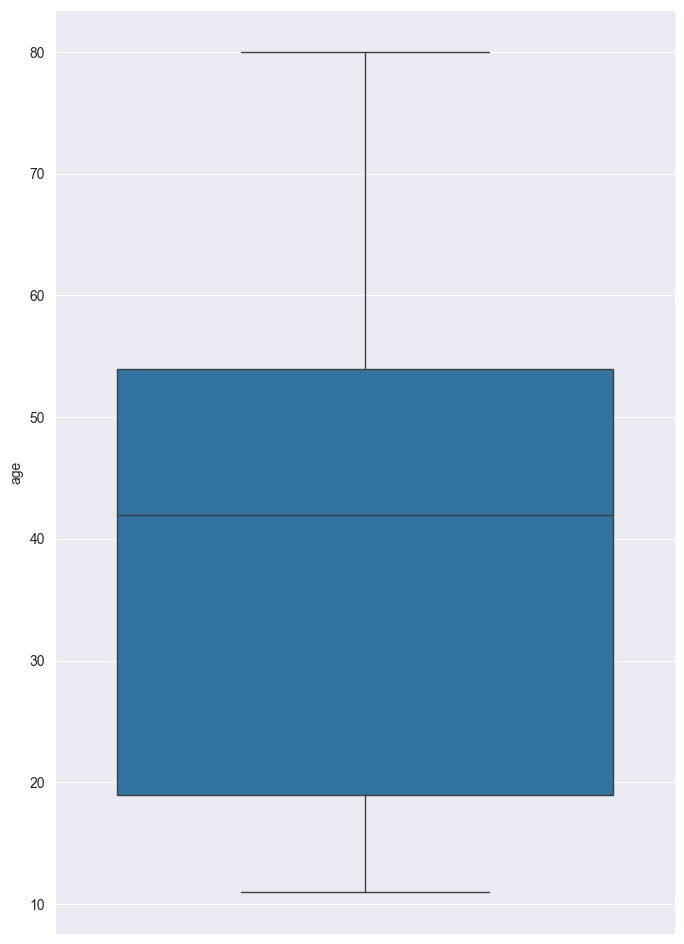

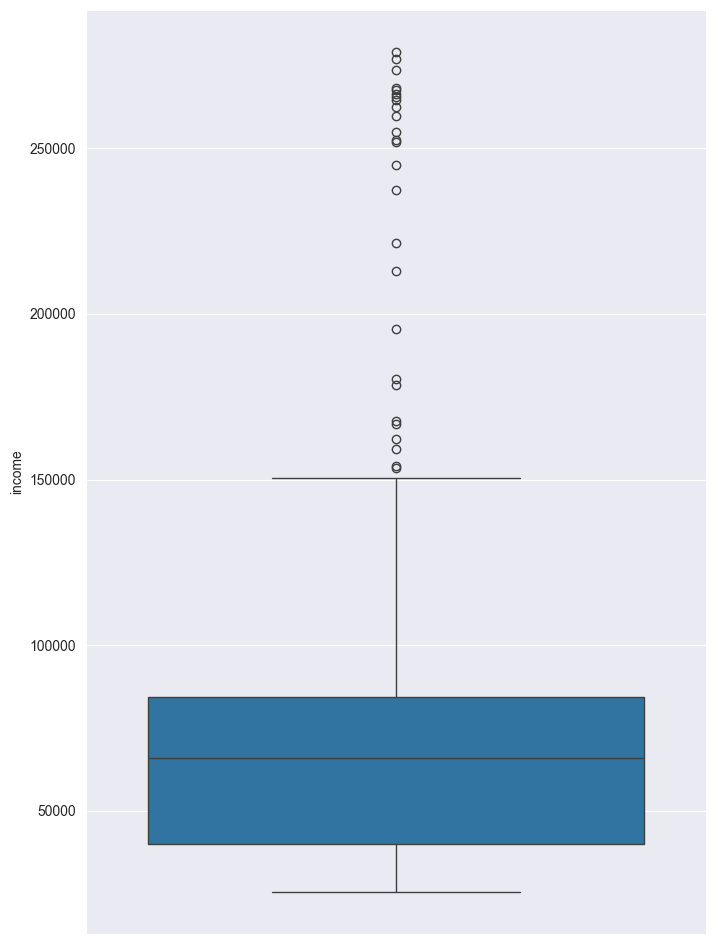

In [406]:
# Построим боксплот по возрасту
plt.figure(figsize=(8, 12))
sns.boxplot(y='age', data=df)
plt.savefig('../plots/age_boxplot.png', bbox_inches="tight", pad_inches=0)
plt.show()

# Построим боксплот по инкаму
plt.figure(figsize=(8, 12))
sns.boxplot(y='income', data=df)
plt.savefig('../plots/income_boxplot.png', bbox_inches="tight", pad_inches=0)
plt.show()

In [407]:
# Очистим данные от выбросов
df = df[df['age'] >= 20]
df = df[df['income']<= 150000]

In [408]:
# Поделим на возрастные группы
def age_category(age):
    if age <= 35:
        return 'junior'
    elif age <= 55:
        return 'middle'
    else:
        return 'senior'
    
df['age_category'] = df['age'].apply(age_category)

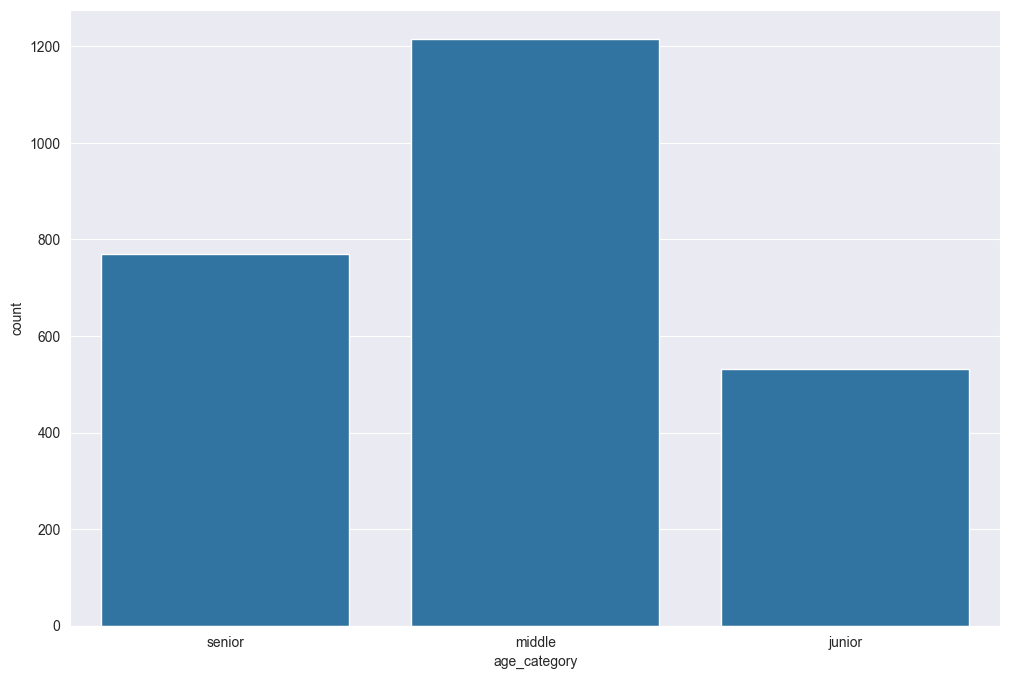

In [409]:
# Построил барплот по возрастным группам
plt.figure(figsize=(12, 8))
sns.countplot(x='age_category', data=df)
plt.savefig('../plots/age_categories.png', bbox_inches="tight", pad_inches=0)

In [410]:
# Введем новый признак - суммарный исход всех рекламных кампаний
df['marketing_company_outcome'] = df['marketing_company_outcome_1'] + df['marketing_company_outcome_2'] + df['marketing_company_outcome_3'] + df['marketing_company_outcome_4'] + df['marketing_company_outcome_5']

# Введем новый признак - количество покупок
df['purchases'] = df['catalogue_purchases_count_avg']  + df['store_purchases_count_avg'] + df['website_purchases_count_avg'] + df['mobile_purchases_count_avg']

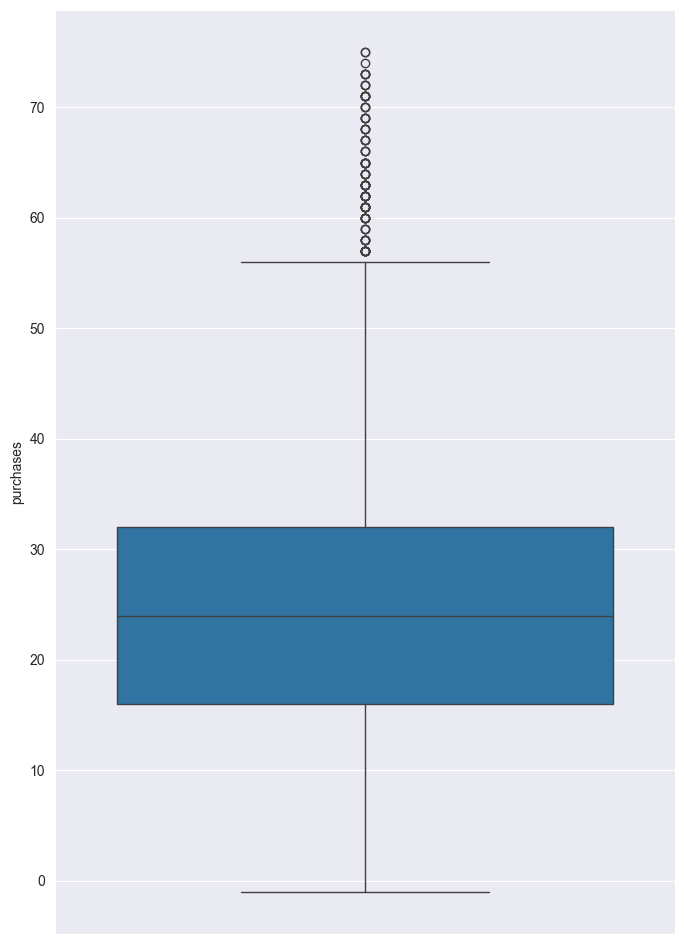

In [411]:
# Построим боксплот по количеству покупок

plt.figure(figsize=(8, 12))
sns.boxplot(y='purchases', data=df)
plt.savefig('../plots/purchases_boxplot.png', bbox_inches="tight", pad_inches=0)
plt.show()

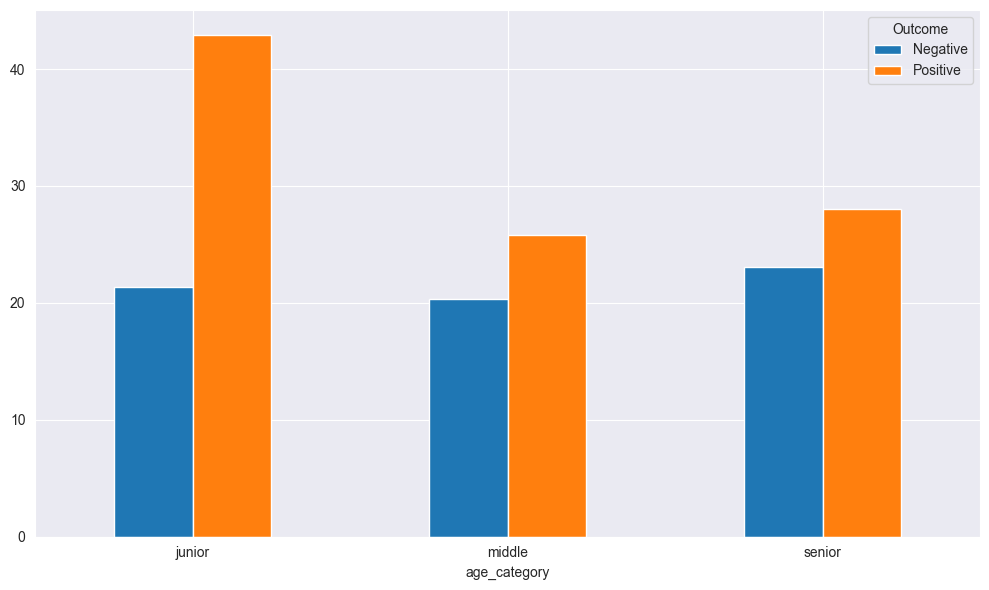

In [412]:
positive = df[df[f'marketing_company_outcome'] >= 1]
negative = df[df[f'marketing_company_outcome'] < 1]

positive = positive.groupby('age_category')['purchases'].mean().reset_index()
negative = negative.groupby('age_category')['purchases'].mean().reset_index()

positive['Outcome'] = 'Positive'
negative['Outcome'] = 'Negative'

combined = pd.concat([positive, negative])

# Pivot the data for plotting
combined_pivot = combined.pivot(index='age_category', columns='Outcome', values='purchases')

# Plotting
combined_pivot.plot(kind='bar', figsize=(10, 6))
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../plots/purchases_by_age_category.png', bbox_inches="tight", pad_inches=0)
plt.show()

In [413]:
positive_junior_purchases = df[(df['age_category'] == 'junior') & (df['marketing_company_outcome'] == 1)]['purchases']
negative_junior_purchases = df[(df['age_category'] == 'junior') & (df['marketing_company_outcome'] == 0)]['purchases']

positive_middle_purchases = df[(df['age_category'] == 'middle') & (df['marketing_company_outcome'] == 1)]['purchases']
negative_middle_purchases = df[(df['age_category'] == 'middle') & (df['marketing_company_outcome'] == 0)]['purchases']

positive_senior_purchases = df[(df['age_category'] == 'senior') & (df['marketing_company_outcome'] == 1)]['purchases']
negative_senior_purchases = df[(df['age_category'] == 'senior') & (df['marketing_company_outcome'] == 0)]['purchases']

# Посчитаем дисперсию
variance_junior_positive = np.var(positive_junior_purchases)
variance_junior_negative = np.var(negative_junior_purchases)

variance_middle_positive = np.var(positive_middle_purchases)
variance_middle_negative = np.var(negative_middle_purchases)

variance_senior_positive = np.var(positive_senior_purchases)
variance_senior_negative = np.var(negative_senior_purchases)

print(f"Junior positive purchases variance: {variance_junior_positive}")
print(f"Junior negative purchases variance: {variance_junior_negative}")

print(f"Middle positive purchases variance: {variance_middle_positive}")
print(f"Middle negative purchases variance: {variance_middle_negative}")

print(f"Senior positive purchases variance: {variance_senior_positive}")
print(f"Senior negative purchases variance: {variance_senior_negative}")

Junior positive purchases variance: 251.69367283950618
Junior negative purchases variance: 168.68643435157816
Middle positive purchases variance: 105.3858024691358
Middle negative purchases variance: 85.82739688677374
Senior positive purchases variance: 86.61266429048786
Senior negative purchases variance: 101.46744884491282


In [414]:
# Проверим гипотезу о равенстве средних
t_value_junior, p_value_junior = stats.ttest_ind(positive_junior_purchases, negative_junior_purchases, equal_var=False)
t_value_middle, p_value_middle = stats.ttest_ind(positive_middle_purchases, negative_middle_purchases, equal_var=False)
t_value_senior, p_value_senior = stats.ttest_ind(positive_senior_purchases, negative_senior_purchases, equal_var=False)

print(f"Junior t-value: {t_value_junior}, p-value: {p_value_junior}")
print(f"Middle t-value: {t_value_middle}, p-value: {p_value_middle}")
print(f"Senior t-value: {t_value_senior}, p-value: {p_value_senior}")

Junior t-value: 7.42945081947039, p-value: 2.492636380118391e-11
Middle t-value: 4.490619919903599, p-value: 1.1812440612594985e-05
Senior t-value: 5.513653223145771, p-value: 1.0293883612177558e-07


In [415]:
# Вычислим коэффициент Коэна
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

d_value_junior = cohen_d(positive_junior_purchases, negative_junior_purchases)
d_value_middle = cohen_d(positive_middle_purchases, negative_middle_purchases)
d_value_senior = cohen_d(positive_senior_purchases, negative_senior_purchases)

print(f"Junior Cohen's d: {d_value_junior}")
print(f"Middle Cohen's d: {d_value_middle}")
print(f"Senior Cohen's d: {d_value_senior}")

Junior Cohen's d: 1.129013058415463
Middle Cohen's d: 0.41057892314604416
Senior Cohen's d: 0.5027893187251639


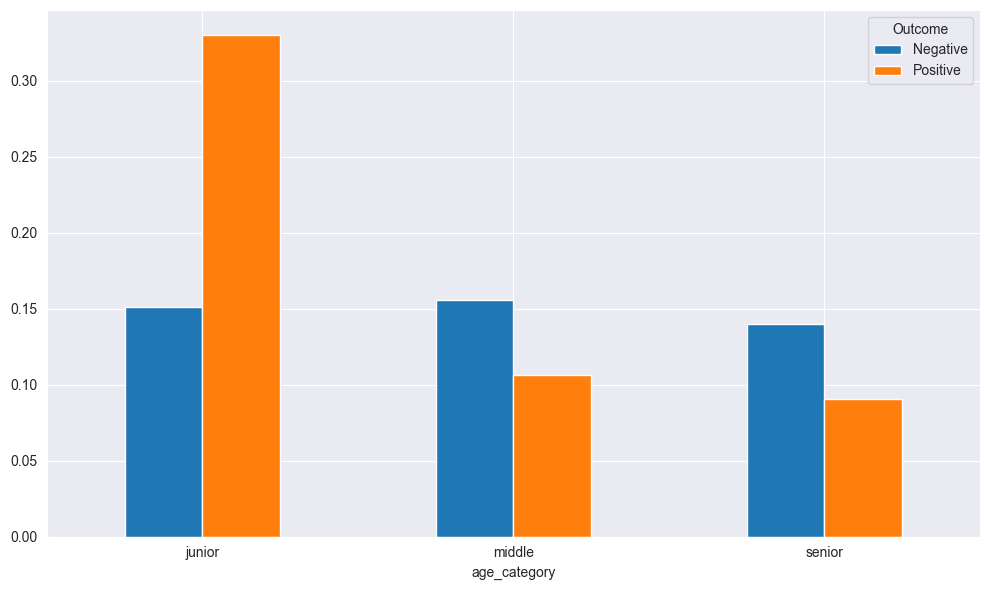

In [416]:
# Построим график процента акционных товаров по возрастным категориям и влиянии рекламных кампаний
df['promo_percent'] = np.where(df['purchases'] > 0, df['discount_purchases_count_avg'] / df['purchases'], 0)

positive = df[df[f'marketing_company_outcome'] >= 1]
negative = df[df[f'marketing_company_outcome'] < 1]

positive = positive.groupby('age_category')['promo_percent'].mean().reset_index()
negative = negative.groupby('age_category')['promo_percent'].mean().reset_index()

positive['Outcome'] = 'Positive'
negative['Outcome'] = 'Negative'

combined = pd.concat([positive, negative])

combined_pivot = combined.pivot(index='age_category', columns='Outcome', values='promo_percent')

combined_pivot.plot(kind='bar', figsize=(10, 6))
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../plots/promo_percent_by_age_category.png', bbox_inches="tight", pad_inches=0)
plt.show()


In [417]:
# Сопоставим статистику по чекам с пользователями, которые совершили покупку

df['fish'] = np.zeros(len(df))
df['sweets'] = np.zeros(len(df))
df['fruits'] = np.zeros(len(df))
df['alcohol'] = np.zeros(len(df))
df['meat'] = np.zeros(len(df))
df['vegetables'] = np.zeros(len(df))
df['other'] = np.zeros(len(df))

df['sum_bill'] = np.zeros(len(df))

for index, row in orderdata.iterrows():
    userid = row['userid']
    category = row['category']
    price = row['avg_bill']

    df_index = df[df['userid'] == userid].index
    if not df_index.empty:
        scalar_index = df_index[0]
        if category == 'fish':
            df.at[scalar_index, 'fish'] = price
        elif category == 'sweets':
            df.at[scalar_index, 'sweets'] = price
        elif category == 'fruits':
            df.at[scalar_index, 'fruits'] = price
        elif category == 'alcohol':
            df.at[scalar_index, 'alcohol'] = price
        elif category == 'meat':
            if (np.isnan(price)):
                df.at[scalar_index, 'meat'] = 0
            else:
                df.at[scalar_index, 'meat'] = price
        elif category == 'vegetables':
            df.at[scalar_index, 'vegetables'] = price
        else:
            df.at[scalar_index, 'other'] = price

        df.at[scalar_index, 'sum_bill'] += price

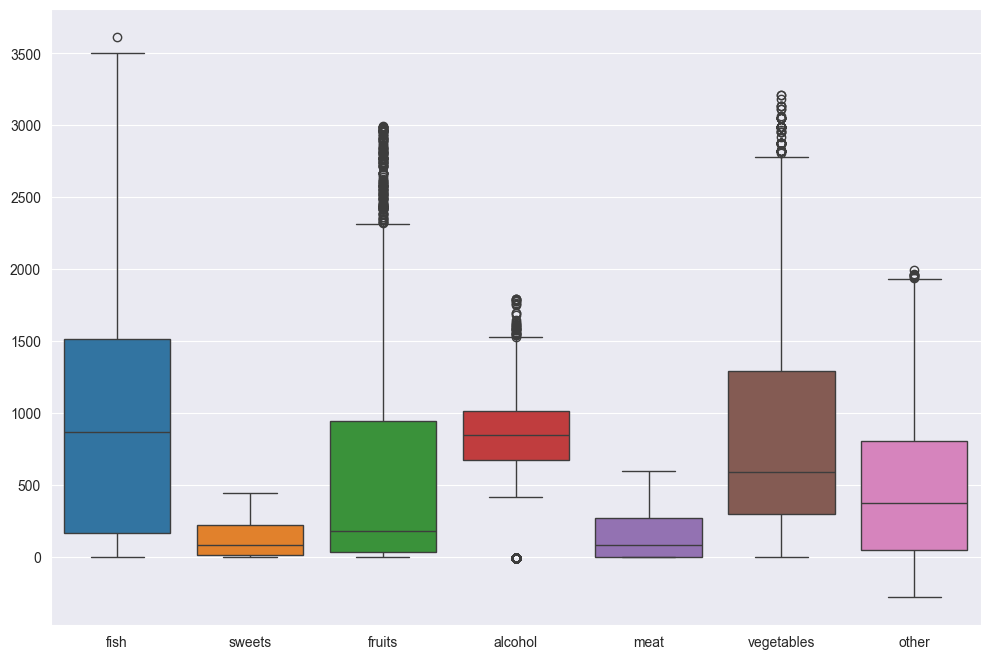

In [418]:
# Сделаем 7 боксплотов для каждой категории товаров на 1 фото
# TODO Ниже не очень важные темы
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[['fish', 'sweets', 'fruits', 'alcohol', 'meat', 'vegetables', 'other']])
plt.savefig('../plots/categories_boxplot.png', bbox_inches="tight", pad_inches=0)
plt.show()

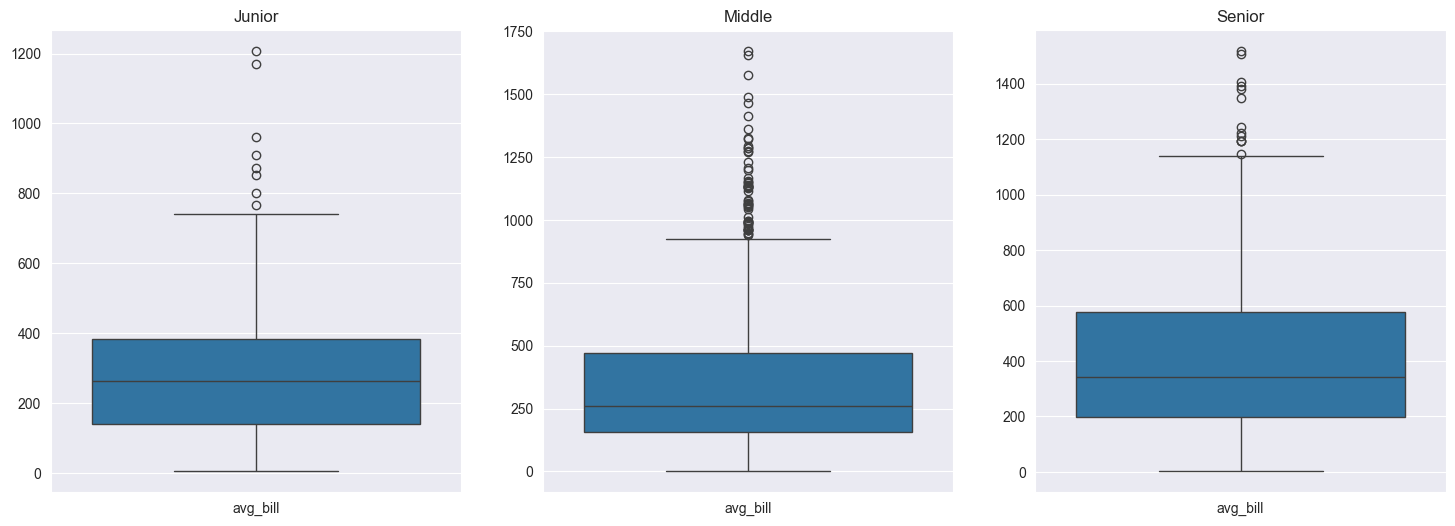

In [419]:
df['avg_bill'] = df['sum_bill'] / 7
df['avg_bill'] = df['avg_bill'].replace(0, np.nan)

junior_df = df[df['age_category'] == 'junior']
middle_df = df[df['age_category'] == 'middle']
senior_df = df[df['age_category'] == 'senior']

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust the figure size as needed

# Plot Junior boxplot
sns.boxplot(data=junior_df[['avg_bill']], ax=axes[0])
axes[0].set_title('Junior')

# Plot Middle boxplot
sns.boxplot(data=middle_df[['avg_bill']], ax=axes[1])
axes[1].set_title('Middle')

# Plot Senior boxplot
sns.boxplot(data=senior_df[['avg_bill']], ax=axes[2])
axes[2].set_title('Senior')

# Save the figure
plt.savefig('../plots/age_category_bill_boxplots.png', bbox_inches="tight", pad_inches=0)
plt.show()

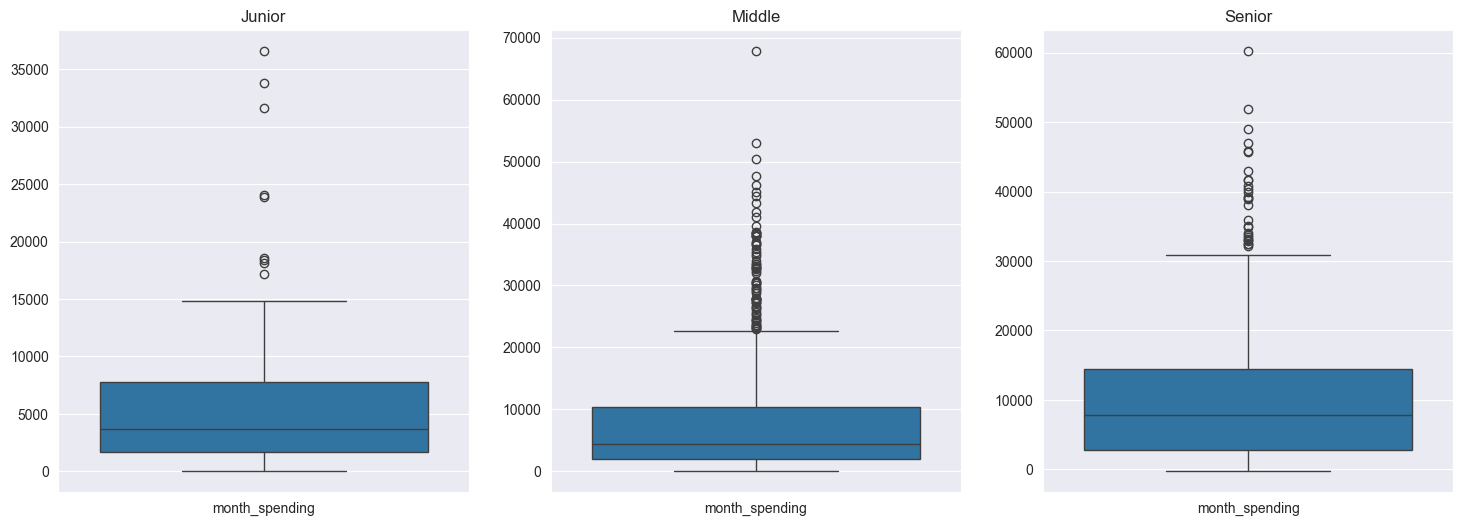

In [420]:
# Построим 3 боксплота по месячным тратам

df['month_spending'] = df['avg_bill'] * df['purchases']

junior_df = df[df['age_category'] == 'junior']
middle_df = df[df['age_category'] == 'middle']
senior_df = df[df['age_category'] == 'senior']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust the figure size as needed

# Plot Junior boxplot
sns.boxplot(data=junior_df[['month_spending']], ax=axes[0])
axes[0].set_title('Junior')

# Plot Middle boxplot
sns.boxplot(data=middle_df[['month_spending']], ax=axes[1])
axes[1].set_title('Middle')

# Plot Senior boxplot
sns.boxplot(data=senior_df[['month_spending']], ax=axes[2])
axes[2].set_title('Senior')

# Save the figure
plt.savefig('../plots/age_category_month_spending_boxplots.png', bbox_inches="tight", pad_inches=0)
plt.show()

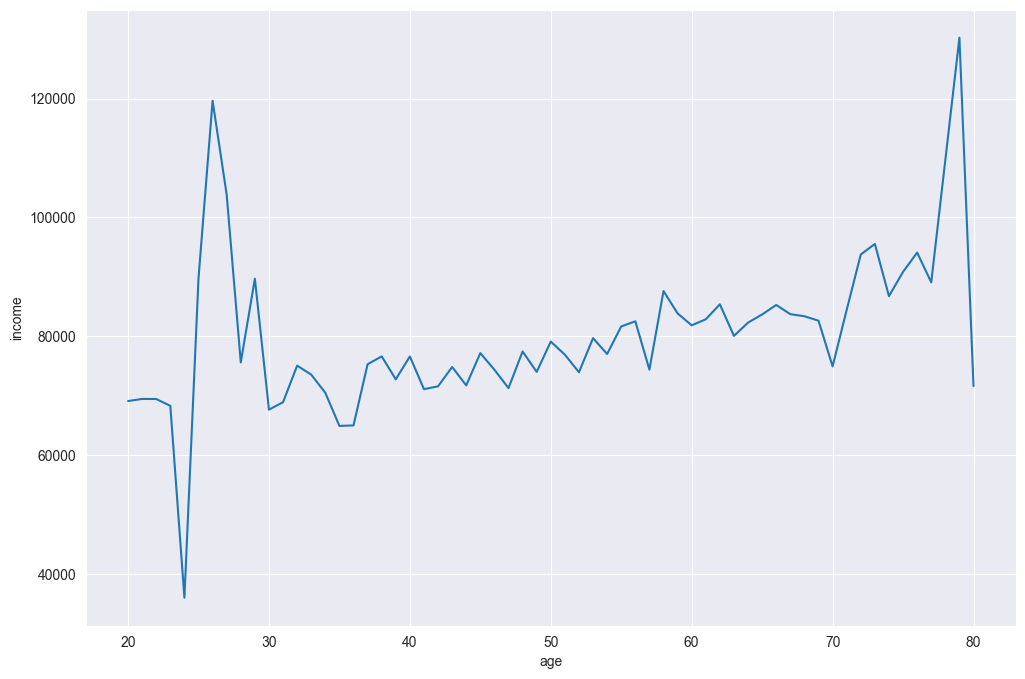

In [421]:
# Построим график income по возрасту
data_for_income_plot = df.groupby('age')['income'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(x='age', y='income', data=data_for_income_plot)
plt.savefig('../plots/income_by_age.png', bbox_inches="tight", pad_inches=0)
plt.show()

In [422]:
# Построим линейную регрессию income по возрасту

X = data_for_income_plot['age'].values.reshape(-1, 1)
y = data_for_income_plot['income'].values

reg = LinearRegression().fit(X, y)

# Оцени работу
r_sq = reg.score(X, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.1811482110022471


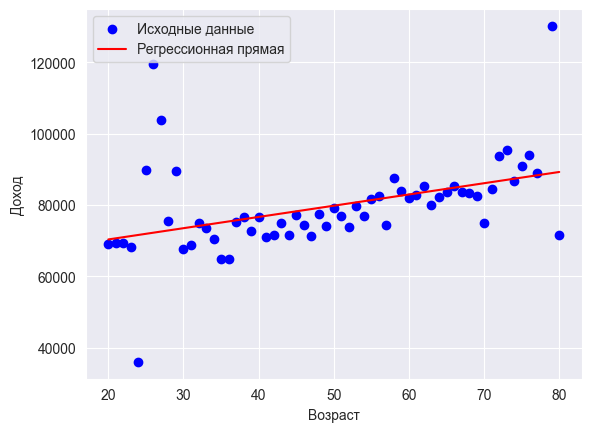

In [423]:
import numpy as np
import matplotlib.pyplot as plt

# Предполагается, что X, y, и reg уже определены, как в вашем примере кода

# Генерация значений X для регрессионной прямой
X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

# Вычисление соответствующих значений Y для регрессионной прямой
y_line = reg.predict(X_line)

# Построение графика
plt.scatter(X, y, color='blue', label='Исходные данные')  # Исходные данные
plt.plot(X_line, y_line, color='red', label='Регрессионная прямая')  # Регрессионная прямая
plt.xlabel('Возраст')
plt.ylabel('Доход')
plt.legend()
plt.show()

In [430]:
def minimax(series):
    return (series - series.min()) / (series.max() - series.min())


data_for_income_plot['income'] = minimax(data_for_income_plot['income'])

X = data_for_income_plot['age'].values.reshape(-1, 1)
y = data_for_income_plot['income'].values

reg = LinearRegression().fit(X, y)

r_sq = reg.score(X, y)
mse = np.mean((reg.predict(X) - y) ** 2)
mae = np.mean(np.abs(reg.predict(X) - y))
print('coefficient of determination:', r_sq)
print('mean squared error:', mse)
print('mean absolute error:', mae)

coefficient of determination: 0.1811482110022472
mean squared error: 0.01527902749181269
mean absolute error: 0.06847826206904155


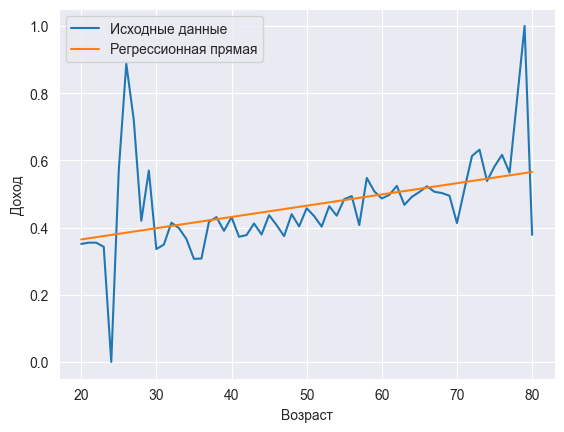

In [429]:
X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

# Вычисление соответствующих значений Y для регрессионной прямой
y_line = reg.predict(X_line)

# Построение графика
# Использование lineplot для обоих наборов данных
sns.lineplot(x=X.ravel(), y=y, label='Исходные данные')
plt.plot(X_line.ravel(), y_line, label='Регрессионная прямая')  # Регрессионная прямая остается plt.plot для сохранения линейности
plt.xlabel('Возраст')
plt.ylabel('Доход')
plt.legend()
plt.savefig('../plots/income_by_age_regression.png', bbox_inches="tight", pad_inches=0)
plt.show()

In [431]:
# Найдем корреляцию age и income

correlation = data_for_income_plot['age'].corr(data_for_income_plot['income'])
print('correlation:', correlation)

correlation: 0.4256150972442675
